In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

In [2]:
df = pd.read_parquet('../data/cleaned/electricity.parquet')
df = df[['index', 'MT_124']]
df = df.rename(columns={'MT_124': 'Electricity_Consumption'})
df.columns

Index(['index', 'Electricity_Consumption'], dtype='object')

Implement 24h differencing 

In [3]:
df['index'] = pd.to_datetime(df['index'])
# Ensure the 'index' column is set as the DataFrame index for time-based operations
df.set_index('index', inplace=True)

# Calculate the difference with the value from 24 hours ago
df['Consumption_Diff_24h'] = df['Electricity_Consumption'] - df['Electricity_Consumption'].shift(freq='24H')

# Reset index if needed for further processing
df.reset_index(inplace=True)
df[85:100]
df = df.dropna().reset_index(drop=True)


/var/folders/x_/ddb0n6pj05b30418_q03dft00000gn/T/ipykernel_15992/661653245.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['Consumption_Diff_24h'] = df['Electricity_Consumption'] - df['Electricity_Consumption'].shift(freq='24H')


In [4]:
df = df[0:500]
df

,index,Electricity_Consumption,Consumption_Diff_24h
0,2011-01-02 00:15:00,411.483254,339.712919
1,2011-01-02 00:30:00,406.698565,334.928230
2,2011-01-02 00:45:00,325.358852,263.157895
3,2011-01-02 01:00:00,344.497608,272.727273
4,2011-01-02 01:15:00,411.483254,344.497608
...,...,...,...
495,2011-01-07 04:00:00,143.540670,14.354067
496,2011-01-07 04:15:00,124.401914,14.354067
497,2011-01-07 04:30:00,100.478469,4.784689
498,2011-01-07 04:45:00,86.124402,4.784689


## Stationarity Analysis

In [5]:
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings('ignore')

def stationarity_analysis(df, dataset_name, column_name = None):
    """
    column_name: specify the column to analyze, default is 'Close'
    Perform ADF and KPSS tests for stationarity analysis
    """
    data = df['Close'] if column_name is None else df[column_name]
    
    data.dropna(inplace=True)  # Drop NaN values for accurate testing
    
    print(f"\n{'='*50}")
    print(f"STATIONARITY ANALYSIS: {dataset_name.upper()}")
    print(f"{'='*50}")
    
    # ADF Test
    print("\n--- AUGMENTED DICKEY-FULLER TEST ---")
    adf_result = adfuller(data, autolag='AIC')
    print(f"ADF Statistic: {adf_result[0]:.6f}")
    print(f"p-value: {adf_result[1]:.6f}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value:.6f}")
    
    if adf_result[1] <= 0.05:
        print("ADF Result: STATIONARY (Reject null hypothesis)")
    else:
        print("ADF Result: NON-STATIONARY (Fail to reject null hypothesis)")
    
    # KPSS Test
    print("\n--- KWIATKOWSKI-PHILLIPS-SCHMIDT-SHIN TEST ---")
    kpss_result = kpss(data, regression='c', nlags='auto')
    print(f"KPSS Statistic: {kpss_result[0]:.6f}")
    print(f"p-value: {kpss_result[1]:.6f}")
    print("Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"\t{key}: {value:.6f}")
    
    if kpss_result[1] <= 0.05:
        print("KPSS Result: NON-STATIONARY (Reject null hypothesis)")
    else:
        print("KPSS Result: STATIONARY (Fail to reject null hypothesis)")
    
    # Combined interpretation
    print("\n--- COMBINED INTERPRETATION ---")
    adf_stationary = adf_result[1] <= 0.05
    kpss_stationary = kpss_result[1] > 0.05
    
    if adf_stationary and kpss_stationary:
        print("CONCLUSION: Series is STATIONARY")
    elif not adf_stationary and not kpss_stationary:
        print("CONCLUSION: Series is NON-STATIONARY")
    else:
        print("CONCLUSION: Results are INCONCLUSIVE - further investigation needed")

# stationarity_analysis(df=df, dataset_name="Elec_Raws", column_name='Electricity_Consumption')
# stationarity_analysis(df=df, dataset_name="Elec_Diff_24h", column_name='Consumption_Diff_24h')

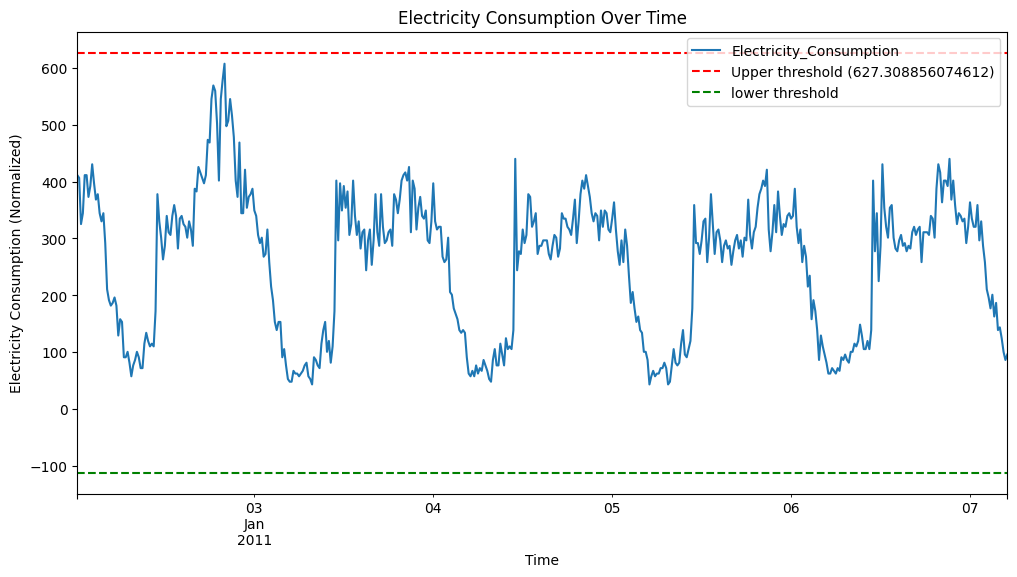

In [6]:
df.plot(x='index', y='Electricity_Consumption', title='Electricity Consumption Over Time', figsize=(12, 6))
# draw two horisontal lines at y=0.2 and y=0.8
STD = 3
df['Electricity_Consumption'].mean(), df['Electricity_Consumption'].std()
UTH = df['Electricity_Consumption'].mean() + STD*df['Electricity_Consumption'].std()
LTH = df['Electricity_Consumption'].mean() - STD*df['Electricity_Consumption'].std()
plt.axhline(y=df['Electricity_Consumption'].mean() + STD*df['Electricity_Consumption'].std(), color='r', linestyle='--', label=f'Upper threshold ({UTH})')
plt.axhline(y=df['Electricity_Consumption'].mean() - STD*df['Electricity_Consumption'].std(), color='g', linestyle='--', label='lower threshold')
plt.xlabel('Time')
plt.ylabel('Electricity Consumption (Normalized)')
plt.legend()
plt.show()

In [7]:
df['Electricity_Consumption'].mean(), df['Electricity_Consumption'].std()

# count the number of outliers in the Electricity_Consumption column
outliers = df[(df['Electricity_Consumption'] > df['Electricity_Consumption'].mean() + 3*df['Electricity_Consumption'].std()) | (df['Electricity_Consumption'] < df['Electricity_Consumption'].mean() - 3*df['Electricity_Consumption'].std())]
print(len(outliers))
outliers

mean_lr = df['Electricity_Consumption'].mean()
std_lr = df['Electricity_Consumption'].std()
CLAMP_STD = 3

upper = mean_lr + CLAMP_STD * std_lr
lower = mean_lr - CLAMP_STD * std_lr

df['Electricity_Consumption'] = np.where(df['Electricity_Consumption'] > upper, upper,
                        np.where(df['Electricity_Consumption'] < lower, lower, df['Electricity_Consumption']))


# count the number of outliers in the Electricity_Consumption column
outliers = df[(df['Electricity_Consumption'] > UTH) | (df['Electricity_Consumption'] < LTH)]
len(outliers)
# outliers


0


0

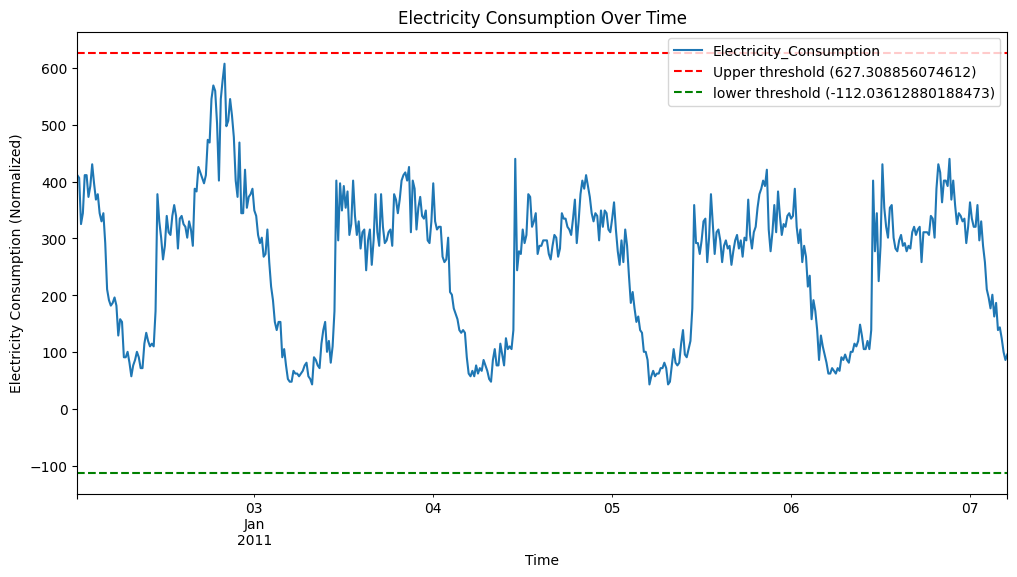

In [8]:
df.plot(x='index', y='Electricity_Consumption', title='Electricity Consumption Over Time', figsize=(12, 6))
# draw two horisontal lines at y=0.2 and y=0.8
STD = 3
df['Electricity_Consumption'].mean(), df['Electricity_Consumption'].std()
plt.axhline(y=df['Electricity_Consumption'].mean() + STD*df['Electricity_Consumption'].std(), color='r', linestyle='--', label=f'Upper threshold ({UTH})')
plt.axhline(y=df['Electricity_Consumption'].mean() - STD*df['Electricity_Consumption'].std(), color='g', linestyle='--', label=f'lower threshold ({LTH})')
plt.xlabel('Time')
plt.ylabel('Electricity Consumption (Normalized)')
plt.legend()
plt.show()

In [9]:
# Step 3: Data Preparation (No global scaling; features exclude Date and LogRet)
features = ['Consumption_Diff_24h']
X = df[features].values
y = df['Consumption_Diff_24h'].shift(-1).dropna().values  # Next LogRet; len N-1
X = X[:-1]  # Align; assume df sorted by Date

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit  # For guidance, but implementing custom rolling for financial data

# Step 1: Define Elman RNN Model
class ElmanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(ElmanRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Step 2: Custom Dataset for Sequences
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets, seq_len=10):
        self.data = data
        self.targets = targets
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.data) - self.seq_len
    
    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_len]
        y = self.targets[idx + self.seq_len]
        return torch.FloatTensor(x), torch.FloatTensor([y])

class JordanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        """
        Jordan RNN Model. The num_layers parameter is kept for API consistency
        but this implementation uses a single hidden layer.
        """
        super(JordanRNN, self).__init__()
        self.hidden_size = hidden_size
        
        # The RNN cell takes the input and the combined hidden+previous_output state
        self.rnn_cell = nn.RNNCell(input_size + output_size, hidden_size)
        
        # Fully connected layer to produce the output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Get batch size and sequence length
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        # Initialize hidden state and output for the first time step
        hidden = torch.zeros(batch_size, self.hidden_size).to(x.device)
        prev_output = torch.zeros(batch_size, self.fc.out_features).to(x.device)

        # Manually loop through each time step in the sequence
        for t in range(seq_len):
            # Concatenate current input with the previous time step's output
            combined_input = torch.cat((x[:, t, :], prev_output), dim=1)
            
            # Update the hidden state
            hidden = self.rnn_cell(combined_input, hidden)
            
            # The output for this step is based on the new hidden state
            prev_output = self.fc(hidden)
            
        # The final output is the output from the last time step
        return prev_output
    
class MultiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        """
        Multi-Recurrent Neural Network (MultiRNN) - Combination of Elman and Jordan RNNs
        
        This network feeds back both:
        1. Previous hidden state (like Elman RNN)
        2. Previous output (like Jordan RNN)
        
        Args:
            input_size: Number of input features
            hidden_size: Number of hidden units
            output_size: Number of output features
            num_layers: Number of layers (kept for API consistency, uses single layer)
        """
        super(MultiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # The RNN cell takes input + previous_hidden + previous_output
        # Input concatenation: [current_input, prev_hidden, prev_output]
        self.rnn_cell = nn.RNNCell(input_size + hidden_size + output_size, hidden_size)
        
        # Fully connected layer to produce the output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass through the MultiRNN
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_size)
            
        Returns:
            Output tensor of shape (batch_size, output_size)
        """
        # Get batch size and sequence length
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        # Initialize hidden state and output for the first time step
        hidden = torch.zeros(batch_size, self.hidden_size).to(x.device)
        prev_output = torch.zeros(batch_size, self.output_size).to(x.device)

        # Manually loop through each time step in the sequence
        for t in range(seq_len):
            # Concatenate current input, previous hidden state, and previous output
            # This is the key difference: we use BOTH prev_hidden and prev_output
            combined_input = torch.cat((x[:, t, :], hidden, prev_output), dim=1)
            
            # Update the hidden state using the combined input
            hidden = self.rnn_cell(combined_input, hidden)
            
            # Calculate the current output based on the new hidden state
            current_output = self.fc(hidden)
            
            # Update prev_output for the next time step
            prev_output = current_output
            
        # Return the final output (output from the last time step)
        return current_output


## Model parameters and train validation test splitting

In [11]:
# Parameters
seq_len = 10
batch_size = 32
num_layers = 1
epochs = 500
n_folds = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = len(features)
output_size = 1

model_to_use = 'Elman'  # or Elman

# --- New: one overarching train/holdout split at the beginning (holdout is the last chunk of the series)
holdout_ratio = 0.3  # fraction kept for final test at the end
n_total = len(X)
holdout_size = int(holdout_ratio * n_total)
if holdout_size < seq_len + 1:
    raise ValueError("Holdout set too small for the chosen seq_len; reduce holdout_ratio or seq_len.")

# Training and validation portion
X_trainval = X[:-holdout_size]
y_trainval = y[:-holdout_size]

# Held out portion
X_holdout = X[-holdout_size:]
y_holdout = y[-holdout_size:]

# --- Growing-window CV on the training+validation portion
results = {'fold': [], 'rmse': [], 'mae': []}

n_trainval = len(X_trainval)
# initial training window inside trainval (choose a sensible starting window)
initial_train_ratio = 0.5
initial_train_window = max(int(initial_train_ratio * n_trainval), seq_len + 1)
remaining = n_trainval - initial_train_window
if remaining < n_folds:  # ensure at least one sample per test fold
    raise ValueError("Not enough data in training portion to create the requested number of folds. Reduce n_folds or holdout_ratio.")

fold_test_size = max(1, remaining // n_folds)

### Gridsearch CV

In [12]:
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error

def gridsearchCV_RNNs(model_to_use='Elman'):

    # Step 1: Define the grid of hyperparameters to search over
    # Keep this small initially, as grid search is computationally expensive!
    param_grid = {
        'hidden_size': range(150, 200, 10),
        'learning_rate': [0.001, 0.005, 0.01, 0.015, 0.02],  # Use a list of floats instead of range
        'seq_len': range(10, 31, 10),
    }

    # --- Parameters for Early Stopping ---
    epochs = 500  # Max number of epochs
    patience = 75 # How many epochs to wait for improvement before stopping

    # --- Store results for each parameter combination ---
    grid_search_results = []
    keys, values = zip(*param_grid.items())

    # Step 2: Outer loop for Grid Search
    for v in itertools.product(*values):
        params = dict(zip(keys, v))
        
        # Unpack current hyperparameters
        hidden_size = params['hidden_size']
        learning_rate = params['learning_rate']
        seq_len = params['seq_len']
        # You can unpack others like batch_size here if you add them to the grid
        
        print(f"\n{'='*60}")
        print(f"TESTING HYPERPARAMETERS: {params}")
        print(f"{'='*60}")
        
        # Store results for the folds of this specific parameter set
        current_param_fold_results = {'rmse': [], 'mae': []}

        # Step 3: Inner loop for Growing-Window Cross-Validation (your original code)
        for fold in range(n_folds):
            train_start = 0
            train_end = initial_train_window + fold * fold_test_size
            test_start = train_end
            test_end = min(test_start + fold_test_size, n_trainval)

            # Ensure there's enough data for at least one sequence
            if train_end - train_start < seq_len + 1 or test_end - test_start < seq_len + 1:
                print(f"Skipping fold {fold}: Insufficient data for seq_len={seq_len}")
                continue

            # Extract fold data
            X_tr, y_tr = X_trainval[train_start:train_end], y_trainval[train_start:train_end]
            X_te, y_te = X_trainval[test_start:test_end], y_trainval[test_start:test_end]

            # Scale PER FOLD
            scaler_X = StandardScaler().fit(X_tr)
            X_tr_scaled = scaler_X.transform(X_tr)
            X_te_scaled = scaler_X.transform(X_te)
            scaler_y = StandardScaler().fit(y_tr.reshape(-1, 1))
            y_tr_scaled = scaler_y.transform(y_tr.reshape(-1, 1)).flatten()
            y_te_scaled = scaler_y.transform(y_te.reshape(-1, 1)).flatten()

            # Create datasets & loaders with the current seq_len
            train_dataset = TimeSeriesDataset(X_tr_scaled, y_tr_scaled, seq_len)
            # The test_dataset is now our validation set for early stopping
            val_dataset = TimeSeriesDataset(X_te_scaled, y_te_scaled, seq_len) 
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            # Initialize model with current hyperparameters
            if model_to_use == 'Jordan':
                model = JordanRNN(input_size, hidden_size, output_size, num_layers).to(device)
            elif model_to_use == 'Elman':
                model = ElmanRNN(input_size, hidden_size, output_size, num_layers).to(device)
            elif model_to_use == 'Multi':
                model = MultiRNN(input_size, hidden_size, output_size, num_layers).to(device)
            else:
                raise ValueError("Invalid model_to_use specified.")
            
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            # --- Training with Early Stopping ---
            best_val_loss = float('inf')
            patience_counter = 0
            
            for epoch in range(epochs):
                model.train()
                for batch_x, batch_y in train_loader:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                    optimizer.zero_grad()
                    outputs = model(batch_x)
                    loss = criterion(outputs.squeeze(), batch_y)
                    loss.backward()
                    optimizer.step()

                # Validation phase for early stopping
                model.eval()
                val_loss = 0
                with torch.no_grad():
                    for batch_x, batch_y in val_loader:
                        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                        outputs = model(batch_x)
                        val_loss += criterion(outputs.squeeze(), batch_y).item()
                
                val_loss /= len(val_loader)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    # Optional: save the best model state
                    torch.save(model.state_dict(), f'{model_to_use}_best_model_fold.pth')
                else:
                    patience_counter += 1
                
                if patience_counter >= patience:
                    # print(f"Fold {fold}: Early stopping at epoch {epoch+1}")
                    break
            
            # Load the best model for evaluation
            model.load_state_dict(torch.load(f'{model_to_use}_best_model_fold.pth'))

            # Evaluation on this fold's test block
            model.eval()
            predictions = []
            with torch.no_grad():
                for batch_x, _ in val_loader: # Use the same validation loader
                    batch_x = batch_x.to(device)
                    outputs = model(batch_x)
                    predictions.extend(outputs.squeeze().cpu().numpy())

            predictions = np.array(predictions)
            true_y = y_te_scaled[seq_len:]
            predictions = predictions[:len(true_y)]

            rmse = np.sqrt(mean_squared_error(true_y, predictions))
            mae = mean_absolute_error(true_y, predictions)

            current_param_fold_results['rmse'].append(rmse)
            current_param_fold_results['mae'].append(mae)

        # After all folds for the current param set are done, calculate the average score
        if current_param_fold_results['rmse']: # Check if any folds ran
            mean_rmse = np.mean(current_param_fold_results['rmse'])
            mean_mae = np.mean(current_param_fold_results['mae'])
            
            # print(f"\n--- Avg CV Score for {params}: RMSE = {mean_rmse:.4f}, MAE = {mean_mae:.4f} ---")
            
            grid_search_results.append({
                'params': params,
                'mean_rmse': mean_rmse,
                'mean_mae': mean_mae
            })

    # Step 4: Find and print the best hyperparameter combination
    if grid_search_results:
        best_params_result = min(grid_search_results, key=lambda x: x['mean_rmse'])
        print(f"\n{'='*60}")
        print("GRID SEARCH COMPLETE for model:", model_to_use)
        print(f"Best Hyperparameters found: {best_params_result['params']}")
        print(f"Best Mean CV RMSE: {best_params_result['mean_rmse']:.4f}")
        print(f"{'='*60}")
        return best_params_result
    else:
        print("\nGrid search did not complete. Check data size and parameters.")

# Final Testing

### Preparing final testing data

In [13]:


# Final: retrain on entire trainval and evaluate once on the held-out end-of-series test set
# Fit scalers on whole trainval
scaler_X_full = StandardScaler().fit(X_trainval)
X_trainval_scaled = scaler_X_full.transform(X_trainval)
X_holdout_scaled = scaler_X_full.transform(X_holdout)

scaler_y_full = StandardScaler().fit(y_trainval.reshape(-1, 1))
y_trainval_scaled = scaler_y_full.transform(y_trainval.reshape(-1, 1)).flatten()
y_holdout_scaled = scaler_y_full.transform(y_holdout.reshape(-1, 1)).flatten()


# Final Elman

In [14]:
best_params_result = gridsearchCV_RNNs(model_to_use='Elman')


TESTING HYPERPARAMETERS: {'hidden_size': 150, 'learning_rate': 0.001, 'seq_len': 10}

TESTING HYPERPARAMETERS: {'hidden_size': 150, 'learning_rate': 0.001, 'seq_len': 20}

TESTING HYPERPARAMETERS: {'hidden_size': 150, 'learning_rate': 0.001, 'seq_len': 30}

TESTING HYPERPARAMETERS: {'hidden_size': 150, 'learning_rate': 0.005, 'seq_len': 10}

TESTING HYPERPARAMETERS: {'hidden_size': 150, 'learning_rate': 0.005, 'seq_len': 20}

TESTING HYPERPARAMETERS: {'hidden_size': 150, 'learning_rate': 0.005, 'seq_len': 30}

TESTING HYPERPARAMETERS: {'hidden_size': 150, 'learning_rate': 0.01, 'seq_len': 10}

TESTING HYPERPARAMETERS: {'hidden_size': 150, 'learning_rate': 0.01, 'seq_len': 20}

TESTING HYPERPARAMETERS: {'hidden_size': 150, 'learning_rate': 0.01, 'seq_len': 30}

TESTING HYPERPARAMETERS: {'hidden_size': 150, 'learning_rate': 0.015, 'seq_len': 10}

TESTING HYPERPARAMETERS: {'hidden_size': 150, 'learning_rate': 0.015, 'seq_len': 20}

TESTING HYPERPARAMETERS: {'hidden_size': 150, 'learning_

In [15]:
# Train final model on entire trainval
train_dataset_full = TimeSeriesDataset(X_trainval_scaled, y_trainval_scaled,  seq_len=best_params_result['params']['seq_len'])
holdout_dataset = TimeSeriesDataset(X_holdout_scaled, y_holdout_scaled,  seq_len=best_params_result['params']['seq_len'])
train_loader_full = DataLoader(train_dataset_full, batch_size=batch_size, shuffle=False)
holdout_loader = DataLoader(holdout_dataset, batch_size=batch_size, shuffle=False)

final_model = ElmanRNN(input_size, best_params_result['params']['hidden_size'], output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params_result['params']['learning_rate'])
final_model.train()

for epoch in range(epochs):
    for batch_x, batch_y in train_loader_full:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = final_model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()

# Evaluate on holdout
final_model.eval()
predictions = []
true_vals = []
with torch.no_grad():
    for batch_x, batch_y in holdout_loader:
        batch_x = batch_x.to(device)
        outputs = final_model(batch_x)
        predictions.extend(outputs.squeeze().cpu().numpy())
        true_vals.extend(batch_y.numpy().flatten())

predictions = np.array(predictions)
true_y = np.array(true_vals)

rmse_holdout = np.sqrt(mean_squared_error(true_y, predictions))
mae_holdout = mean_absolute_error(true_y, predictions)

print(f"\nFinal Holdout Test (on last {holdout_size} samples): RMSE = {rmse_holdout:.4f}, MAE = {mae_holdout:.4f}")

# Optional: inverse-transform to original y scale for more interpretable metrics
y_pred_inv = scaler_y_full.inverse_transform(predictions.reshape(-1, 1)).flatten()
y_true_inv = scaler_y_full.inverse_transform(true_y.reshape(-1, 1)).flatten()
rmse_holdout_orig = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
mae_holdout_orig = mean_absolute_error(y_true_inv, y_pred_inv)
print(f"Final Holdout Test (original y scale): RMSE = {rmse_holdout_orig:.6f}, MAE = {mae_holdout_orig:.6f}")



Final Holdout Test (on last 149 samples): RMSE = 0.4840, MAE = 0.4010
Final Holdout Test (original y scale): RMSE = 52.664041, MAE = 43.630413


# Final Jordan

In [ ]:
best_params_result = gridsearchCV_RNNs(model_to_use='Jordan')

In [ ]:
train_dataset_full = TimeSeriesDataset(X_trainval_scaled, y_trainval_scaled,  seq_len=best_params_result['params']['seq_len'])
holdout_dataset = TimeSeriesDataset(X_holdout_scaled, y_holdout_scaled,  seq_len=best_params_result['params']['seq_len'])
train_loader_full = DataLoader(train_dataset_full, batch_size=batch_size, shuffle=False)
holdout_loader = DataLoader(holdout_dataset, batch_size=batch_size, shuffle=False)

# Train final model on entire trainval
final_model = JordanRNN(input_size, best_params_result['params']['hidden_size'], output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params_result['params']['learning_rate'])
final_model.train()

for epoch in range(epochs):
    for batch_x, batch_y in train_loader_full:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = final_model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()

# Evaluate on holdout
final_model.eval()
predictions = []
true_vals = []
with torch.no_grad():
    for batch_x, batch_y in holdout_loader:
        batch_x = batch_x.to(device)
        outputs = final_model(batch_x)
        predictions.extend(outputs.squeeze().cpu().numpy())
        true_vals.extend(batch_y.numpy().flatten())

predictions = np.array(predictions)
true_y = np.array(true_vals)

rmse_holdout = np.sqrt(mean_squared_error(true_y, predictions))
mae_holdout = mean_absolute_error(true_y, predictions)

print(f"\nFinal Holdout Test (on last {holdout_size} samples): RMSE = {rmse_holdout:.4f}, MAE = {mae_holdout:.4f}")

# Optional: inverse-transform to original y scale for more interpretable metrics
y_pred_inv = scaler_y_full.inverse_transform(predictions.reshape(-1, 1)).flatten()
y_true_inv = scaler_y_full.inverse_transform(true_y.reshape(-1, 1)).flatten()
rmse_holdout_orig = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
mae_holdout_orig = mean_absolute_error(y_true_inv, y_pred_inv)
print(f"Final Holdout Test (original y scale): RMSE = {rmse_holdout_orig:.6f}, MAE = {mae_holdout_orig:.6f}")

# Final Multi-RNN

In [ ]:
best_params_result = gridsearchCV_RNNs(model_to_use='Multi')

In [ ]:
train_dataset_full = TimeSeriesDataset(X_trainval_scaled, y_trainval_scaled,  seq_len=best_params_result['params']['seq_len'])
holdout_dataset = TimeSeriesDataset(X_holdout_scaled, y_holdout_scaled,  seq_len=best_params_result['params']['seq_len'])
train_loader_full = DataLoader(train_dataset_full, batch_size=batch_size, shuffle=False)
holdout_loader = DataLoader(holdout_dataset, batch_size=batch_size, shuffle=False)

# Train final model on entire trainval
final_model = MultiRNN(input_size, best_params_result['params']['hidden_size'], output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params_result['params']['learning_rate'])
final_model.train()

for epoch in range(epochs):
    for batch_x, batch_y in train_loader_full:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = final_model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()

# Evaluate on holdout
final_model.eval()
predictions = []
true_vals = []
with torch.no_grad():
    for batch_x, batch_y in holdout_loader:
        batch_x = batch_x.to(device)
        outputs = final_model(batch_x)
        predictions.extend(outputs.squeeze().cpu().numpy())
        true_vals.extend(batch_y.numpy().flatten())

predictions = np.array(predictions)
true_y = np.array(true_vals)

rmse_holdout = np.sqrt(mean_squared_error(true_y, predictions))
mae_holdout = mean_absolute_error(true_y, predictions)

print(f"\nFinal Holdout Test (on last {holdout_size} samples): RMSE = {rmse_holdout:.4f}, MAE = {mae_holdout:.4f}")

# Optional: inverse-transform to original y scale for more interpretable metrics
y_pred_inv = scaler_y_full.inverse_transform(predictions.reshape(-1, 1)).flatten()
y_true_inv = scaler_y_full.inverse_transform(true_y.reshape(-1, 1)).flatten()
rmse_holdout_orig = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
mae_holdout_orig = mean_absolute_error(y_true_inv, y_pred_inv)
print(f"Final Holdout Test (original y scale): RMSE = {rmse_holdout_orig:.6f}, MAE = {mae_holdout_orig:.6f}")